# Numerical Torque--Speed Model

This (currently single-phase) model calculates the torque--speed curve numerically.

It starts by attempting to satisfy the constant torque conditions.
If those conditions aren't met, it moves to constant power conditions.
If those aren't met, it uses the BEMF conditions.

/Users/dsoto/opt/miniconda3/envs/ph39/lib/python3.9/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


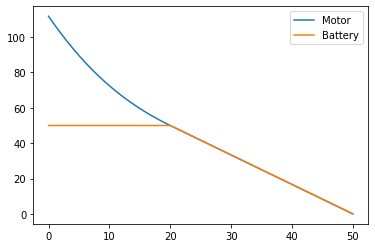

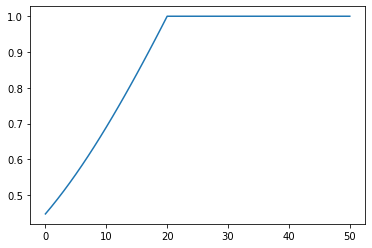

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

Voc = 50
Iout_max = 150
Rb = 0.5
k = 1.0
Rm = 0.1
Iin_max = 100

def motor_voltage(omega, Rm, k, Iout):
    return Iout * Rm + k * omega

def output_power(Iout, Vout):
    return Iout * Vout

def input_power(D, Voc, Rb, Iout, Vout):
    return (Voc - Iout * D * Rb) * Iout * D

def input_voltage(Voc, Rb, Iin):
    return Voc - Rb * Iin

def input_current(Iout, D):
    return Iout * D

def input_power(D, Voc, Rb, Iout, Vout):
    return (Voc - Iout * D * Rb) * Iout * D

def duty_root(D, Voc, Rb, Iout, Vout):
    return input_power(D, Voc, Rb, Iout, Vout) - Iout * Vout

def const_power_duty_root(D, Voc, Iin, Rb, Rm, k, omega):
    # input electrical power minus output resistor and bemf power
    return (Voc - Iin * Rb) * Iin - (Iin / D)**2 * Rm - Iin / D * k * omega

def solve_curve(omega, Voc, Rb, Rm, k, Iout_max, Iin_max):
    # try const torque
    Vout = motor_voltage(omega, Rm, k, Iout_max)
    D_ct = fsolve(duty_root, 0, args=(Voc, Rb, Iout_max, Vout))[0]
    Iin_ct = input_current(D_ct, Iout_max)
    power_out = Vout * Iout_max
    power_in = Iin_ct * input_voltage(Voc, Rb, Iin_ct)
    # if input current, duty cycle, and power look good, record values
    if Iin_ct < Iin_max and D_ct <= 1.0 and abs(power_out - power_in) < 0.1:
        if verbose: print(omega, 'ct', power_out - power_in)
        motor_current = Iout_max
        battery_current = Iin_ct
        duty_cycle = D_ct
        
    # else try const power
    else:
        D_cp = fsolve(const_power_duty_root, 0.01, args=(Voc, Iin_max, Rb, Rm, k, omega))[0]
        Iout = Iin_max / D_cp
        # if duty cycle looks good, record values
        if D_cp <= 1.0:
            power_out = Iout * motor_voltage(omega, Rm, k, Iout)
            power_in = Iin_max * input_voltage(Voc, Rb, Iin_max)
            if verbose: print(omega, 'cp', power_out - power_in)
            battery_current = Iin_max
            motor_current = Iout
            duty_cycle = D_cp
        
        # use BEMF
        else:
            Ibemf = (Voc - k * omega) / (Rb + Rm)    
            power_out = Ibemf * motor_voltage(omega, Rm, k, Ibemf)
            power_in = Ibemf * input_voltage(Voc, Rb, Ibemf)
            if verbose: print(omega, 'b', power_out - power_in)
            #print(omega, 'b', Ibemf)
            motor_current = Ibemf
            battery_current = Ibemf
            duty_cycle = 1

    return motor_current, battery_current, duty_cycle

verbose = False
motor_current = []
battery_current = []
duty_cycle = []
omega_max = Voc / k

if Iin_max > Voc / Rb / 2:
    Iin_max = Voc / Rb / 2

motor_current = []
battery_current = []
duty_cycle = []
omegas = np.linspace(0, omega_max, 51)
for omega in omegas:
    mc, bc, dc = solve_curve(omega, Voc, Rb, Rm, k, Iout_max, Iin_max)
    motor_current.append(mc)
    battery_current.append(bc)
    duty_cycle.append(dc)

plt.plot(omegas, motor_current, label='Motor')
plt.plot(omegas, battery_current, label='Battery')
plt.legend()
plt.show()
plt.plot(omegas, duty_cycle)